In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def execQuery(query):
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "password",
                                      host = "localhost",
                                      port = "5432",
                                      database = "bachelorBesoeg2014")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            #print("Executed query and closed connection.")

result = execQuery("""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;""")
result

[(1794, 475)]

In [3]:
result = execQuery("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tabels = [x[0] for x in result]
tabels

['_775140',
 '_775160',
 '_775100',
 '_775146',
 '_775168',
 '_775167',
 '_775122',
 '_775120',
 '_775144',
 '_775127',
 '_775126',
 '_775170',
 '_775130',
 '_775164',
 '_775150',
 '_775147']

In [4]:
result = execQuery("""select count(*) from _775147 where count_ = 1;""")
print(result)
print(type(result[0][0]))

[(36,)]
<class 'int'>


In [5]:
requests = np.array([1,92,82,48])
ac = np.array([36,11,5,1])

In [6]:
def lap(x,b):
    return 1/(2*b) * np.exp(-(np.abs(x)/b))

In [7]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])

In [38]:
epsilon = 2
b = 1/epsilon
#print(b)
print(2*(b)**2)
laplace_mec = laplace(scale=b)
print(laplace_mec.var())
laplace_mec.rvs()

0.5
0.5


-0.17807014005314645

In [9]:
def laplace_mechanism(answear,epsilon):
    b = 1/epsilon
    laplace_mec = laplace(scale=b)
    Y = laplace_mec.rvs()
    return answear + Y

In [10]:
def range_count(query,epsilon):
    corret_answear = execQuery(query)[0][0]
    return laplace_mechanism(corret_answear,epsilon)

In [11]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [12]:
def confidence_interval(mean, confidence=0.95):
    se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [13]:
error_dicts = {}

for e in epsilons:
    print(e)
    number_of_queries = 100
    query = """select count(*) from _775147 where count_ = 1;"""
    answears = np.zeros(number_of_queries)
    corret_answear = execQuery(query)[0][0]
    for i in range(0,number_of_queries):
        answears[i] = range_count(query,e)
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error }



2.0
1.4
1.2
1.0
0.8
0.7
0.5
0.4
0.3


In [14]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']

In [15]:
error_stack = np.vstack((min_errors,mse_errors,max_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
labels_stack = np.vstack((min_labels,mse_labels,max_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons)).flatten()


In [16]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('seaborn_plotting_data.csv',index=False)

In [17]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors})
all_data.to_csv('plotting_data.csv',index=False)

In [18]:
sns.set()

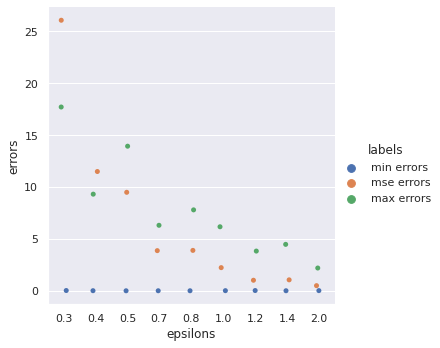

In [19]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.savefig("AllErrors.png")


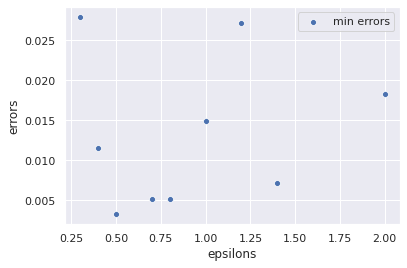

In [20]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('min_error.png') 

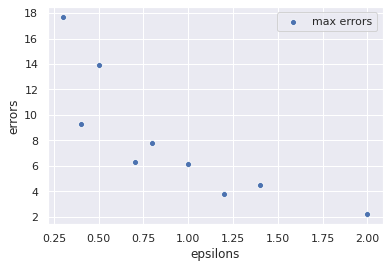

In [21]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'max errors'], x ='epsilons', y ='errors')
plt.legend(labels=['max errors'])
sns_plot.get_figure().savefig('max_error.png') 

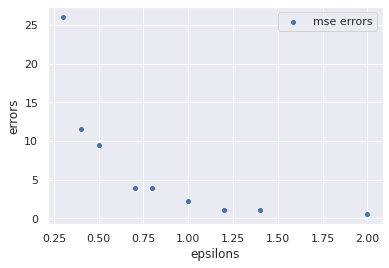

In [22]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'mse errors'], x ='epsilons', y ='errors')
plt.legend(labels=['mse errors'])
sns_plot.get_figure().savefig('mse_error.png') 

In [23]:
def get_means(data):
    means = np.zeros(data.size)
    for i in range(0,data.size):
        means[i] = np.mean(data[0:i+1]) 
    print(np.mean(data))
    return means

In [24]:
def get_confidence(data, std):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    h = 1.96 * (std/np.sqrt(n))
    return m, m-h, m+h

In [25]:
epsilon = 0.8
number_of_queries = 100
b = 1/epsilon
var = 2*(b)**2

query = """select count(*) from _775147 where count_ = 1;"""
answears = np.zeros(number_of_queries)
corret_answear = execQuery(query)[0][0]
for i in range(0,number_of_queries):
    answears[i] = range_count(query,epsilon)
means = get_means(answears)
print(f'corret_answear = {corret_answear}')
print(f'var = {var}, epsilon = {epsilon}, number_of_queries = {number_of_queries}')

35.933367538578025
corret_answear = 36
var = 3.125, epsilon = 0.8, number_of_queries = 100


In [26]:
upper = np.zeros(number_of_queries)
lower = np.zeros(number_of_queries)

for i in range(0,100):
    mean, low, up = get_confidence(answears[0:i+1],var)
    upper[i] = up
    lower[i] = low
    
#upper = upper[-99:] 
#lower = lower[-99:]

In [27]:
print(answears)
print(means)
print(upper)
print(lower)

[35.56501954 34.58644074 32.83906579 37.02876571 35.57404464 35.39181343
 35.84650206 36.35459326 36.63768932 36.17153265 36.06327533 36.52927006
 35.48608961 33.82105914 35.50631456 37.1853887  32.3823524  36.70614542
 34.79519977 36.47348546 36.58783357 38.30304281 34.10812381 36.18312619
 34.54643647 36.66479196 36.2634006  37.48525142 34.82357214 35.71611889
 36.41396501 36.87697685 35.44187912 34.23663195 35.73895528 35.37320898
 36.91938875 37.22722762 37.57583903 35.98675705 37.4187313  36.5724712
 36.6131541  35.66281326 35.33718572 31.41308758 36.66855661 36.05024558
 35.45647623 38.12651794 37.4471072  35.80358332 33.71222282 31.48508138
 36.21468884 35.21418195 37.21105192 35.10527749 33.23992674 35.79499132
 40.87711345 38.13764682 38.14118911 35.02717206 37.8298605  35.34509122
 38.35819594 36.59169732 35.52529904 35.77357964 35.89742425 35.14742307
 37.20094252 34.75307875 34.23075035 35.7788826  35.37022191 36.5221009
 40.72622923 37.41929352 33.32661997 34.77125378 37.6

In [28]:
errors = upper - means

In [29]:

ploting_green = np.abs(errors) < 1
ploting_teal = np.abs(errors) > 1


In [30]:
xs = np.arange(100)+1

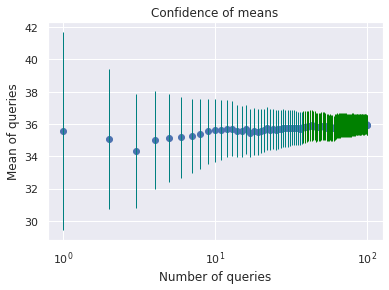

In [31]:
fig = plt.figure(1)
#p1, = plt.plot(xs, ys, 'ro', label='Data points')
#p2, = plt.plot(t, p, 'b-.', label='Approx')
p3 = plt.scatter(xs, means)
plt.vlines(x=xs[ploting_teal], ymin=lower[ploting_teal], ymax=upper[ploting_teal], colors='teal', ls='-', lw=1)
plt.vlines(x=xs[ploting_green], ymin=lower[ploting_green], ymax=upper[ploting_green], colors='green', ls='-', lw=1)


plt.xlabel('Number of queries')
plt.ylabel('Mean of queries')
plt.xscale("log")
plt.title('Confidence of means')
plt.grid(True)
plt.show()

plt.show()
fig.savefig('confidence.png', dpi=fig.dpi)



In [32]:
"""
import numpy as np
import matplotlib.pyplot as plt

xs = np.linspace(1, 21, 200)

plt.figure(figsize=(10, 7))

# only one line may be specified; full height
plt.axvline(x=36, color='b', label='axvline - full height')

# only one line may be specified; ymin & ymax spedified as a percentage of y-range
plt.axvline(x=36.25, ymin=0.05, ymax=0.95, color='b', label='axvline - % of full height')

# multiple lines all full height
plt.vlines(x=[37, 37.25, 37.5], ymin=0, ymax=len(xs), colors='purple', ls='--', lw=2, label='vline_multiple - full height')

# multiple lines with varying ymin and ymax
plt.vlines(x=[38, 38.25, 38.5], ymin=[0, 25, 75], ymax=[200, 175, 150], colors='teal', ls='--', lw=2, label='vline_multiple - partial height')

# single vline with full ymin and ymax
plt.vlines(x=39, ymin=0, ymax=len(xs), colors='green', ls=':', lw=2, label='vline_single - full height')

# single vline with specific ymin and ymax
plt.vlines(x=39.25, ymin=25, ymax=150, colors='green', ls=':', lw=2, label='vline_single - partial height')

# place legend outside
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()
"""

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nxs = np.linspace(1, 21, 200)\n\nplt.figure(figsize=(10, 7))\n\n# only one line may be specified; full height\nplt.axvline(x=36, color='b', label='axvline - full height')\n\n# only one line may be specified; ymin & ymax spedified as a percentage of y-range\nplt.axvline(x=36.25, ymin=0.05, ymax=0.95, color='b', label='axvline - % of full height')\n\n# multiple lines all full height\nplt.vlines(x=[37, 37.25, 37.5], ymin=0, ymax=len(xs), colors='purple', ls='--', lw=2, label='vline_multiple - full height')\n\n# multiple lines with varying ymin and ymax\nplt.vlines(x=[38, 38.25, 38.5], ymin=[0, 25, 75], ymax=[200, 175, 150], colors='teal', ls='--', lw=2, label='vline_multiple - partial height')\n\n# single vline with full ymin and ymax\nplt.vlines(x=39, ymin=0, ymax=len(xs), colors='green', ls=':', lw=2, label='vline_single - full height')\n\n# single vline with specific ymin and ymax\nplt.vlines(x=39.25, ymin=25, ymax=150, colors='g

In [33]:
epsilon1 = 2
epsilon2 = 1
epsilon_combined = epsilon1 + epsilon2
b1 = 1/epsilon1
b2 = 1/epsilon2
b_combined = b1 + b2
var1 = 2*(b1)**2
var2 = 2*(b2)**2
var_combined = var1 + var2
print(epsilon_combined)
print(b_combined)
print(f'var1 = {var1}')
print(f'var2 = {var2}')
print(f'var_combined = {var_combined}')



3
1.5
var1 = 0.5
var2 = 2.0
var_combined = 2.5


In [34]:
epsilon = 2*100
b = 1/epsilon
print(b)
print(2*(b)**2)
laplace_mec = laplace(scale=b)
laplace_mec.var()
laplace_mec.rvs()

0.005
5e-05


-0.0024845906612728807

In [35]:
epsilon = 2
b = 1/epsilon
print(f'b = {b}')
print(f'cal var = {2*(b)**2}')
laplace_mec = laplace(scale=b)
print(f'Lib var = {laplace_mec.var()}')
print(laplace_mec.rvs())

b = 0.5
cal var = 0.5
Lib var = 0.5
0.30168807969822964
